In [189]:

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

%matplotlib inline

#Sklearn
from sklearn.linear_model import LogisticRegression, LinearRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, cross_val_predict
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier, AdaBoostClassifier
from sklearn.pipeline import Pipeline,make_pipeline
from xgboost.sklearn import XGBClassifier
import xgboost as xgb

In [2]:
spotify_df = pd.read_csv('spotify_dataset.csv')
spotify_df.head()

track_title            artist_name  \
0                      Red Planet - Red Planet Radio                    Joe   
1                   Red Planet - Red Planet Extended                    Joe   
2                                           Basejump           Robin Schulz   
3  Goldberg Variations, BWV 988 (Arr. for Accordi...  Johann Sebastian Bach   
4  Goldberg Variations, BWV 988 (Arr. for Accordi...  Johann Sebastian Bach   

                 track_id  duration_ms   energy  key  mode  time_signature  \
0  3FeufAV1f6fajILIQuAXMw       256080  0.96800    7     0               4   
1  2o7oYjZuo3S2QitY4R5dII       395442  0.97000    2     1               4   
2  6nWoNNkfffbmHU9z3kGPao       391680  0.40600    5     0               4   
3  5Zg1UOcmee5oiRw3gbXna0       347840  0.00267    7     0               5   
4  2ZWmWGoZS2OTGZSnMhck7Q       181733  0.22600    7     1               4   

   acousticness  danceability  instrumentalness  liveness  loudness  \
0       0.02150         0.698          0.862000    0.1110   -11.012   
1       0.00339         0.724          0.896000    0.1060    -8.415   
2       0.00433         0.803          0.825000    0.0948    -9.444   
3       0.91000         0.150          0.028700    0.1250   -24.701   
4       0.76800         0.290          0.000002    0.1050   -14.990   

   speechiness  valence    tempo  On_chart  
0       0.0337   0.3900  136.884         0  
1       0.0358   0.4320  136.868         0  
2       0.0608   0.0769  125.014         0  
3       0.0434   0.1050  135.652         0  
4       0.0385   0.4700   98.348         0

In [3]:
spotify_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34740 entries, 0 to 34739
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_title       34739 non-null  object 
 1   artist_name       34739 non-null  object 
 2   track_id          34740 non-null  object 
 3   duration_ms       34740 non-null  int64  
 4   energy            34740 non-null  float64
 5   key               34740 non-null  int64  
 6   mode              34740 non-null  int64  
 7   time_signature    34740 non-null  int64  
 8   acousticness      34740 non-null  float64
 9   danceability      34740 non-null  float64
 10  instrumentalness  34740 non-null  float64
 11  liveness          34740 non-null  float64
 12  loudness          34740 non-null  float64
 13  speechiness       34740 non-null  float64
 14  valence           34740 non-null  float64
 15  tempo             34740 non-null  float64
 16  On_chart          34740 non-null  int64 

In [4]:
spotify_df.isna().sum()

track_title         1
artist_name         1
track_id            0
duration_ms         0
energy              0
key                 0
mode                0
time_signature      0
acousticness        0
danceability        0
instrumentalness    0
liveness            0
loudness            0
speechiness         0
valence             0
tempo               0
On_chart            0
dtype: int64

It looks like there is one blank entry for song name. In the interest of completeness, I will drop this

In [5]:
spotify_df.dropna(subset=['track_title'],inplace=True)
spotify_df.isna().sum()

track_title         0
artist_name         0
track_id            0
duration_ms         0
energy              0
key                 0
mode                0
time_signature      0
acousticness        0
danceability        0
instrumentalness    0
liveness            0
loudness            0
speechiness         0
valence             0
tempo               0
On_chart            0
dtype: int64

In [6]:
#Check for duplicates, there are none
spotify_df[spotify_df.duplicated() == True]

Empty DataFrame
Columns: [track_title, artist_name, track_id, duration_ms, energy, key, mode, time_signature, acousticness, danceability, instrumentalness, liveness, loudness, speechiness, valence, tempo, On_chart]
Index: []

In [7]:
#milliseconds is a counterintuitive way of looking at duration
#for this reason, i will be looking at it in terms of minutes
spotify_df['duration_m'] = spotify_df['duration_ms'] / 60000
spotify_df = spotify_df.drop(columns=['duration_ms'])

spotify_df.head()

track_title            artist_name  \
0                      Red Planet - Red Planet Radio                    Joe   
1                   Red Planet - Red Planet Extended                    Joe   
2                                           Basejump           Robin Schulz   
3  Goldberg Variations, BWV 988 (Arr. for Accordi...  Johann Sebastian Bach   
4  Goldberg Variations, BWV 988 (Arr. for Accordi...  Johann Sebastian Bach   

                 track_id   energy  key  mode  time_signature  acousticness  \
0  3FeufAV1f6fajILIQuAXMw  0.96800    7     0               4       0.02150   
1  2o7oYjZuo3S2QitY4R5dII  0.97000    2     1               4       0.00339   
2  6nWoNNkfffbmHU9z3kGPao  0.40600    5     0               4       0.00433   
3  5Zg1UOcmee5oiRw3gbXna0  0.00267    7     0               5       0.91000   
4  2ZWmWGoZS2OTGZSnMhck7Q  0.22600    7     1               4       0.76800   

   danceability  instrumentalness  liveness  loudness  speechiness  valence  \
0         0.698          0.862000    0.1110   -11.012       0.0337   0.3900   
1         0.724          0.896000    0.1060    -8.415       0.0358   0.4320   
2         0.803          0.825000    0.0948    -9.444       0.0608   0.0769   
3         0.150          0.028700    0.1250   -24.701       0.0434   0.1050   
4         0.290          0.000002    0.1050   -14.990       0.0385   0.4700   

     tempo  On_chart  duration_m  
0  136.884         0    4.268000  
1  136.868         0    6.590700  
2  125.014         0    6.528000  
3  135.652         0    5.797333  
4   98.348         0    3.028883

In [8]:
spotify_df = spotify_df[['track_title', 'artist_name', 'track_id', 'duration_m','energy', 'key', 'mode',
                          'time_signature', 'acousticness', 'danceability', 'instrumentalness',
                          'liveness', 'loudness', 'speechiness', 'valence', 'tempo', 'On_chart']]
spotify_df.head()

track_title            artist_name  \
0                      Red Planet - Red Planet Radio                    Joe   
1                   Red Planet - Red Planet Extended                    Joe   
2                                           Basejump           Robin Schulz   
3  Goldberg Variations, BWV 988 (Arr. for Accordi...  Johann Sebastian Bach   
4  Goldberg Variations, BWV 988 (Arr. for Accordi...  Johann Sebastian Bach   

                 track_id  duration_m   energy  key  mode  time_signature  \
0  3FeufAV1f6fajILIQuAXMw    4.268000  0.96800    7     0               4   
1  2o7oYjZuo3S2QitY4R5dII    6.590700  0.97000    2     1               4   
2  6nWoNNkfffbmHU9z3kGPao    6.528000  0.40600    5     0               4   
3  5Zg1UOcmee5oiRw3gbXna0    5.797333  0.00267    7     0               5   
4  2ZWmWGoZS2OTGZSnMhck7Q    3.028883  0.22600    7     1               4   

   acousticness  danceability  instrumentalness  liveness  loudness  \
0       0.02150         0.698          0.862000    0.1110   -11.012   
1       0.00339         0.724          0.896000    0.1060    -8.415   
2       0.00433         0.803          0.825000    0.0948    -9.444   
3       0.91000         0.150          0.028700    0.1250   -24.701   
4       0.76800         0.290          0.000002    0.1050   -14.990   

   speechiness  valence    tempo  On_chart  
0       0.0337   0.3900  136.884         0  
1       0.0358   0.4320  136.868         0  
2       0.0608   0.0769  125.014         0  
3       0.0434   0.1050  135.652         0  
4       0.0385   0.4700   98.348         0

In [9]:
spotify_df.columns

Index(['track_title', 'artist_name', 'track_id', 'duration_m', 'energy', 'key',
       'mode', 'time_signature', 'acousticness', 'danceability',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'valence',
       'tempo', 'On_chart'],
      dtype='object')

In [10]:
spotify_df.describe()

duration_m        energy           key          mode  time_signature  \
count  34739.000000  34739.000000  34739.000000  34739.000000    34739.000000   
mean       3.649620      0.595008      5.256398      0.646507        3.905323   
std        2.014827      0.237962      3.604646      0.478061        0.472748   
min        0.053383      0.000000      0.000000      0.000000        0.000000   
25%        2.899483      0.445000      2.000000      0.000000        4.000000   
50%        3.533333      0.624000      5.000000      1.000000        4.000000   
75%        4.194667      0.781000      8.000000      1.000000        4.000000   
max       93.500333      1.000000     11.000000      1.000000        5.000000   

       acousticness  danceability  instrumentalness      liveness  \
count  34739.000000  34739.000000      34739.000000  34739.000000   
mean       0.288855      0.601278          0.184095      0.189591   
std        0.309846      0.180965          0.337524      0.164999   
min        0.000000      0.000000          0.000000      0.000000   
25%        0.029900      0.499000          0.000000      0.092900   
50%        0.160000      0.624000          0.000069      0.123000   
75%        0.482000      0.733000          0.105000      0.231000   
max        0.996000      0.988000          1.000000      0.999000   

           loudness   speechiness       valence         tempo      On_chart  
count  34739.000000  34739.000000  34739.000000  34739.000000  34739.000000  
mean      -9.921002      0.096679      0.510253    119.939435      0.501569  
std        5.733943      0.113406      0.268066     29.146269      0.500005  
min      -60.000000      0.000000      0.000000      0.000000      0.000000  
25%      -12.173000      0.035400      0.299000     99.019000      0.000000  
50%       -8.554000      0.049200      0.514000    120.016000      1.000000  
75%       -6.017000      0.097100      0.729000    137.024500      1.000000  
max        2.291000      0.966000      1.000000    247.951000      1.000000

**Feature Engineering and Variable Selection**

The next several steps are utilized to determine how to add feature engineered variables as well as pick the best variables for classification analysis. Correlations between the target variable and between independent variables are considered, as well as pairplots to determine trends.

<AxesSubplot:>

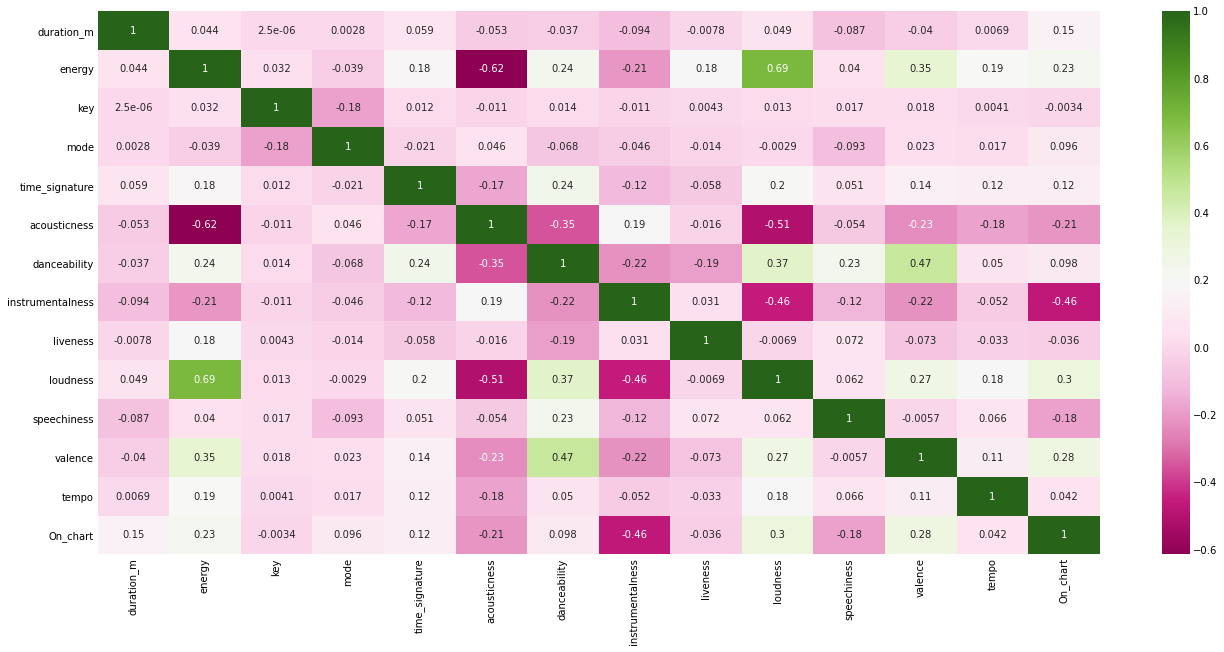

In [11]:
plt.figure(figsize=(20, 10))
sns.heatmap(spotify_df.corr(),annot = True,cmap="PiYG")

In [12]:
spotify_df.columns

Index(['track_title', 'artist_name', 'track_id', 'duration_m', 'energy', 'key',
       'mode', 'time_signature', 'acousticness', 'danceability',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'valence',
       'tempo', 'On_chart'],
      dtype='object')

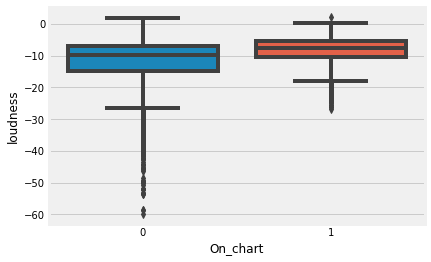

In [13]:
#Energy,acousticness,instrumentalness,loudness,valence all have fairly strong links to chart status
#surprisingly, danceability has minimal link
pair_df = spotify_df.copy()
sns.boxplot(x='On_chart', y='loudness', data=pair_df);

After viewing correlation and box plots, the fields duration_m, energy, acousticness, instrumentalness, valence, speechiness, and loudness all have strong links to whether or not a song is a hit. These variables will be included in the classification analysis.

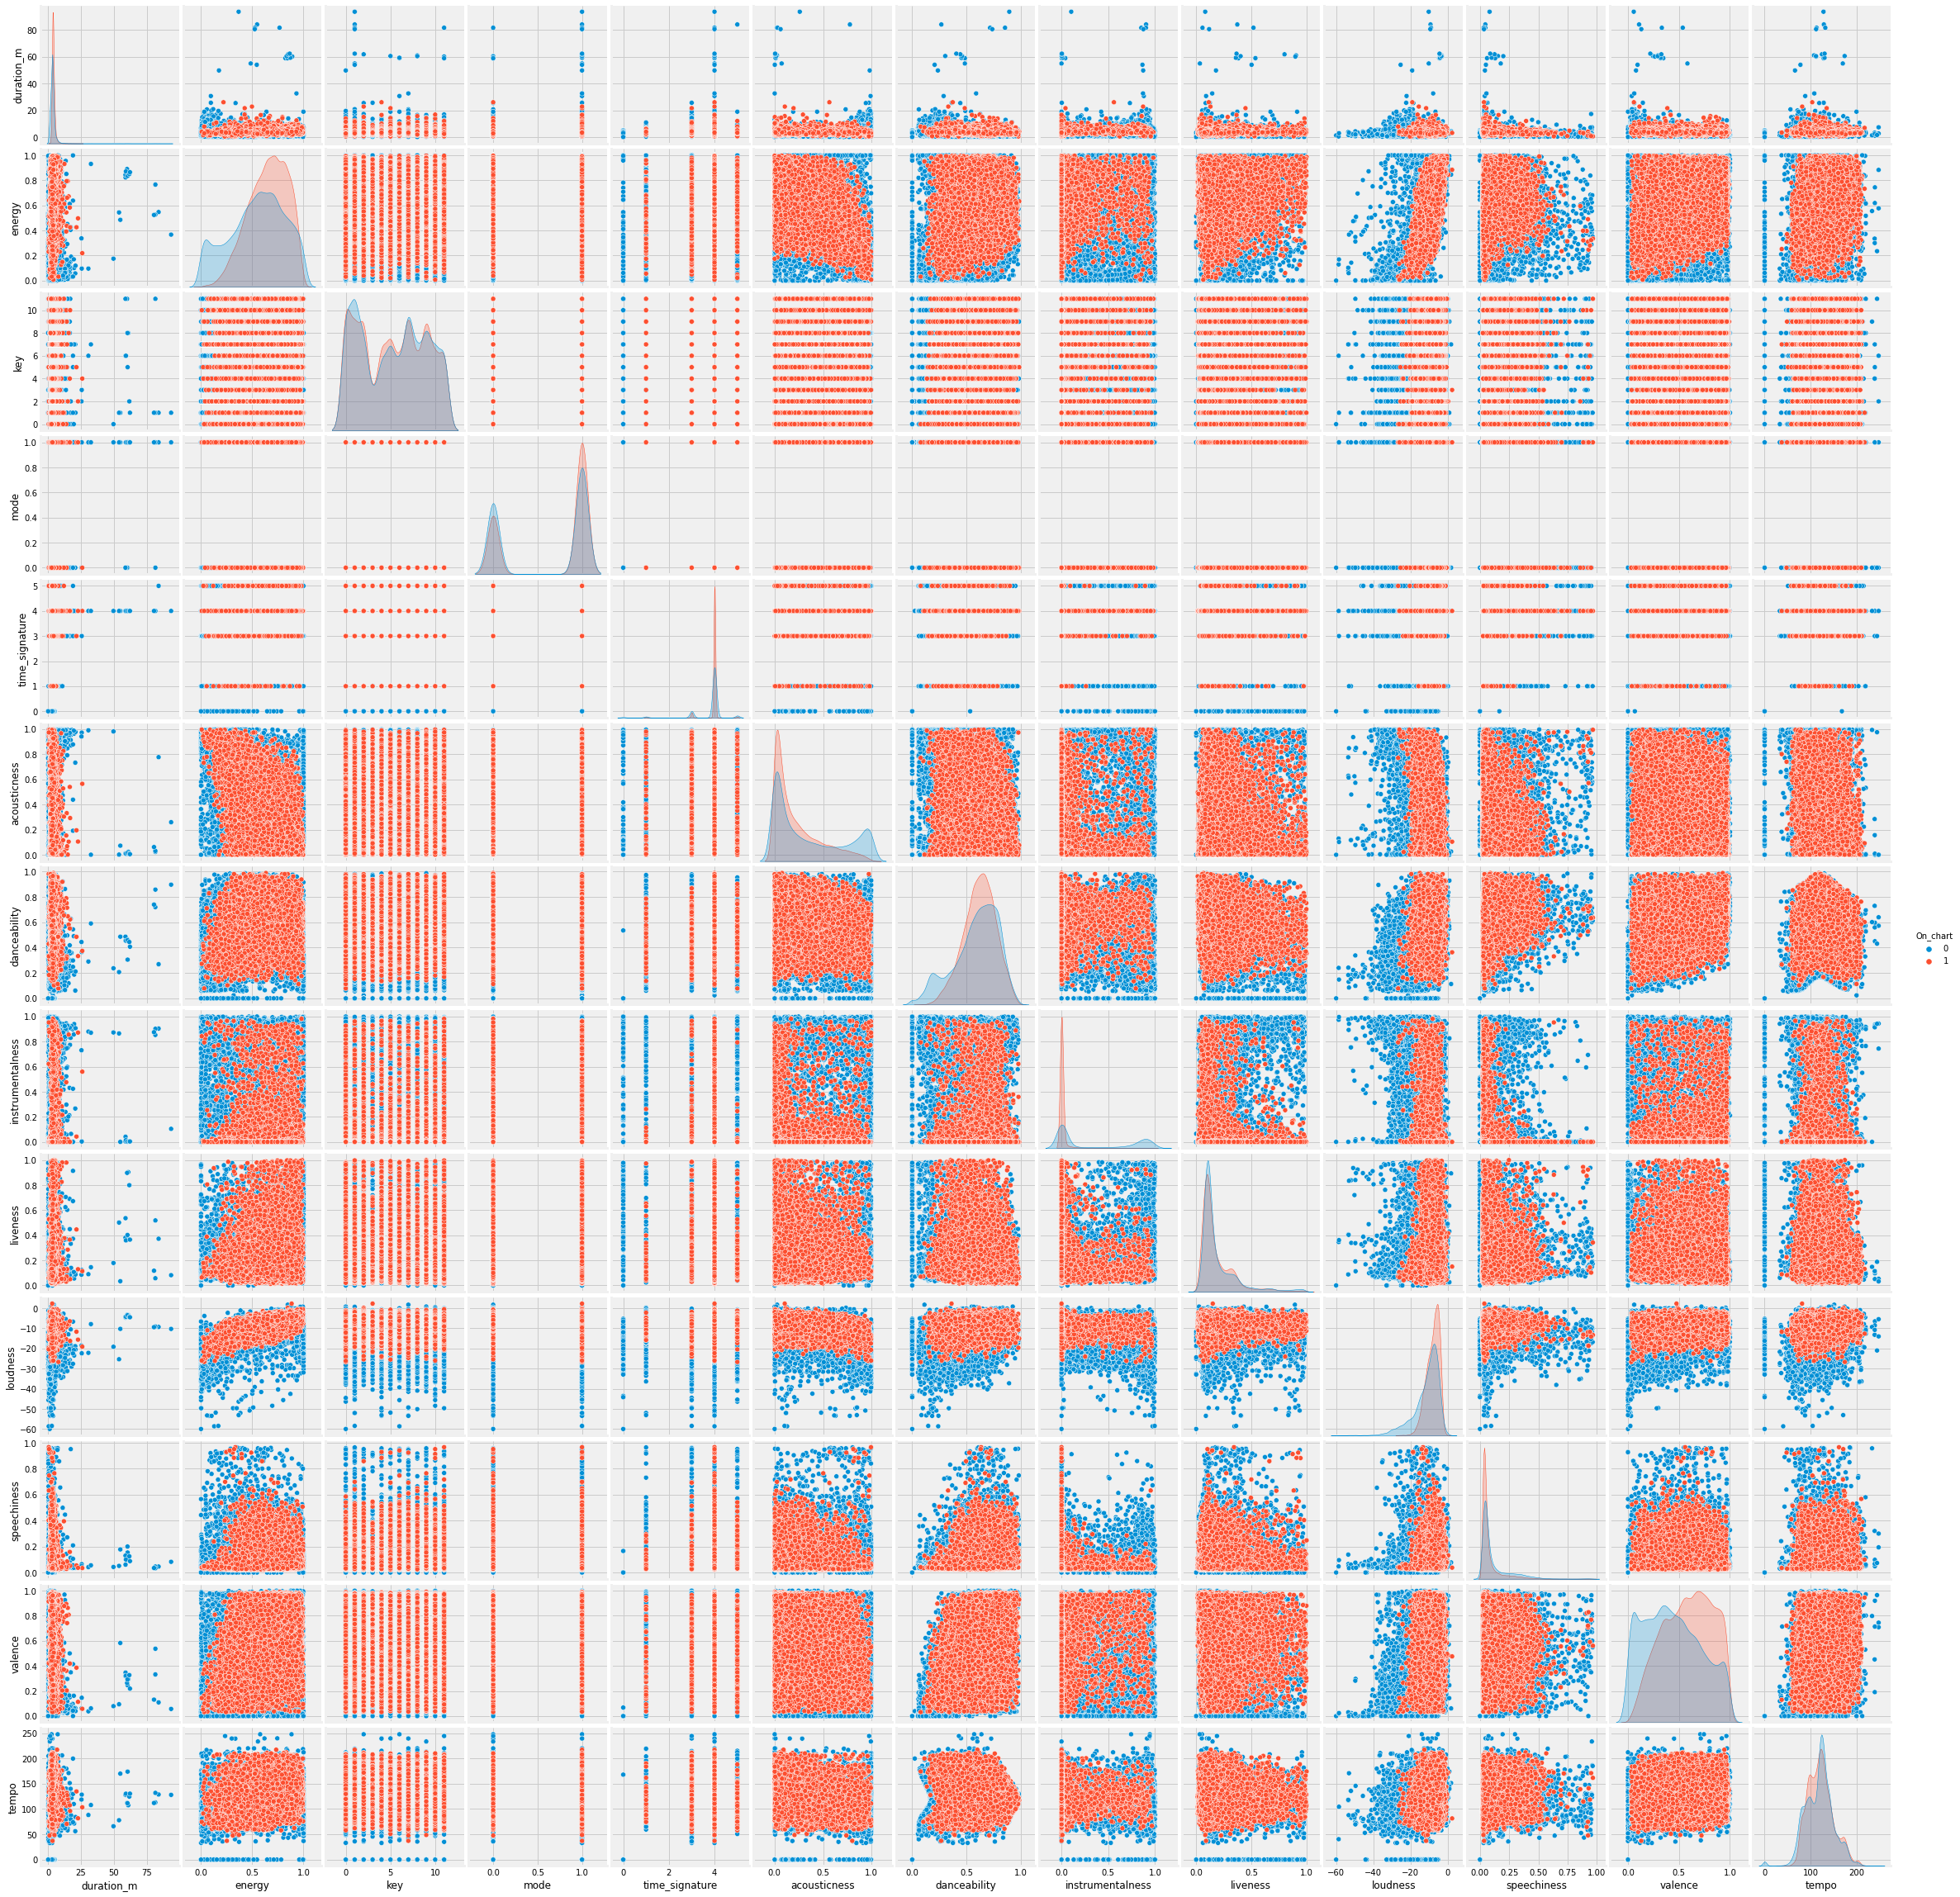

In [14]:

sns.pairplot(pair_df, hue='On_chart')
plt.savefig('pairplot.png');


Feature Engineering

The following fields will be added:
- time_signature dummy variable. 4 beats per measure is almost a unanimous sign of a hit
- There is a steep dropoff in positives below -10 dB, so an indicator variable, "lowloud", will be added
- Hit songs are predominantly pop or hip hop, genres with high energy and danceability. For this reason, an interaction variable, "energyxdance", will be added

In [14]:
#Feature Engineering
#4 beats in a bar is almost a unanimous sign of a hit. 16,588 out of 17,425 hit songs have a 4 beat count
spotify_df2 = pd.get_dummies(spotify_df, columns=['time_signature'])

#there is a steep dropoff in positives identified after -10 dB. Adding indicator variable here
spotify_df2['lowloud'] = spotify_df2['loudness'] < -10
spotify_df2['lowloud'] = spotify_df2['lowloud'].astype(int)

#Hit songs are predominantly pop or hip hop, genres with high energy and danceability
spotify_df2['energyxdance'] = spotify_df['energy'] * spotify_df['danceability']
spotify_df2.head()

track_title            artist_name  \
0                      Red Planet - Red Planet Radio                    Joe   
1                   Red Planet - Red Planet Extended                    Joe   
2                                           Basejump           Robin Schulz   
3  Goldberg Variations, BWV 988 (Arr. for Accordi...  Johann Sebastian Bach   
4  Goldberg Variations, BWV 988 (Arr. for Accordi...  Johann Sebastian Bach   

                 track_id  duration_m   energy  key  mode  acousticness  \
0  3FeufAV1f6fajILIQuAXMw    4.268000  0.96800    7     0       0.02150   
1  2o7oYjZuo3S2QitY4R5dII    6.590700  0.97000    2     1       0.00339   
2  6nWoNNkfffbmHU9z3kGPao    6.528000  0.40600    5     0       0.00433   
3  5Zg1UOcmee5oiRw3gbXna0    5.797333  0.00267    7     0       0.91000   
4  2ZWmWGoZS2OTGZSnMhck7Q    3.028883  0.22600    7     1       0.76800   

   danceability  instrumentalness  ...  valence    tempo  On_chart  \
0         0.698          0.862000  ...   0.3900  136.884         0   
1         0.724          0.896000  ...   0.4320  136.868         0   
2         0.803          0.825000  ...   0.0769  125.014         0   
3         0.150          0.028700  ...   0.1050  135.652         0   
4         0.290          0.000002  ...   0.4700   98.348         0   

   time_signature_0  time_signature_1  time_signature_3  time_signature_4  \
0                 0                 0                 0                 1   
1                 0                 0                 0                 1   
2                 0                 0                 0                 1   
3                 0                 0                 0                 0   
4                 0                 0                 0                 1   

   time_signature_5  lowloud  energyxdance  
0                 0        1      0.675664  
1                 0        0      0.702280  
2                 0        0      0.326018  
3                 1        1      0.000400  
4                 0        1      0.065540  

[5 rows x 23 columns]

**Classification Algorithms**

In [293]:
#Define X, Y, train/test, as well as StandardScaler
X = spotify_df2.drop(columns=['On_chart','track_title','artist_name','track_id'])
X = X[['duration_m','energy','acousticness','instrumentalness','valence','speechiness','loudness',
       'time_signature_4','lowloud','energyxdance']]

y = spotify_df['On_chart']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                       test_size=.2,     
                                       random_state=42)

std_scale = StandardScaler()

X_train_scaled = std_scale.fit_transform(X_train)
X_test_scaled = std_scale.fit_transform(X_test)


Set Baseline f1 score. This is a simplistic model without feature engineering, threshold tuning, or hyperparameter tuning

In [308]:
X2 = X[['duration_m','energy','acousticness','instrumentalness','valence','speechiness','loudness']]
y2 = y.copy()
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, 
                                       test_size=.2,     
                                       random_state=43)
X_train_scaled2 = std_scale.fit_transform(X_train2)
X_test_scaled2 = std_scale.fit_transform(X_test2)

lr_base = LogisticRegression()
lr_base.fit(X_train_scaled2, y_train2)

print(f1_score(y_train2,lr_base.predict(X_train_scaled2)))
print(f1_score(y_test2,lr_base.predict(X_test_scaled2)))

0.7866240990027318
0.7809824838667193


It appears that 0.78 is the baseline threshold to improve upon.

**Model Tuning**

For each model tested, GridSearchCV was used to tune hyperparameters, and threshold tuning was used to optimize the probability threshold with the highest F1 score. Then, a confusion matrix as well as a ROC-AUC curve is populated

Logistic Regression

In [113]:
#Logistic Tuning

param_grid = {
    'C': [.7, 0.8, 1],
    'class_weight': [None, 'balanced'],
    'solver': ['liblinear', 'sag', 'saga']
}

lr = LogisticRegression()
lr.fit(X_train_scaled, y_train)
grid_log = GridSearchCV(lr, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_log.fit(X_train_scaled, y_train)

proba_log = .364
y_predict_log = (grid_log.predict_proba(X_train_scaled)[:,1] >= proba_log)
y_predict_log_test = (grid_log.predict_proba(X_test_scaled)[:,1] >= proba_log)

print("Best estimator: ", grid_log.best_estimator_)
print("Best score at default proba: ", grid_log.best_score_)

print(f'train score is {f1_score(y_train,y_predict_log)}')
print(f'test score is {f1_score(y_test, y_predict_log_test)}')

Best estimator:  LogisticRegression(C=0.7, class_weight='balanced', solver='sag')
Best score at default proba:  0.7859044958122893
train score is 0.7915953021776364
test score is 0.7880201301092428


Logistic Regression Model best F1 score 0.792 at prob decision threshold >= 0.364


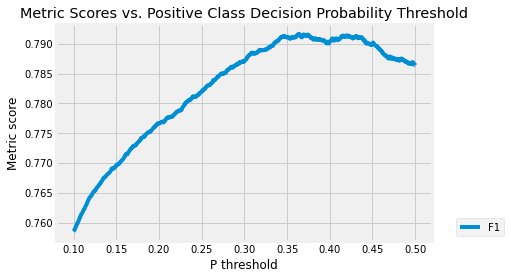

In [118]:
#Threshold Tuning
thresh_ps = np.linspace(.10,.50,1000)
model_val_probs = grid_log.predict_proba(X_train_scaled)[:,1]

f1_scores = []
for p in thresh_ps:
    model_val_labels = model_val_probs >= p
    f1_scores.append(f1_score(y_train, model_val_labels))    
    
plt.plot(thresh_ps, f1_scores)


plt.title('Metric Scores vs. Positive Class Decision Probability Threshold')
plt.legend(['F1'], bbox_to_anchor=(1.05, 0), loc='lower left')
plt.xlabel('P threshold')
plt.ylabel('Metric score')


best_f1_score = np.max(f1_scores) 
best_thresh_p = thresh_ps[np.argmax(f1_scores)]

print('Logistic Regression Model best F1 score %.3f at prob decision threshold >= %.3f' 
      % (best_f1_score, best_thresh_p))

In [298]:
def make_confusion_matrix(model, threshold, model_name):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    if model == grid_rf or model == grid_dt or model == grid_xg:
        y_predict_test = (model.predict_proba(X_test)[:, 1] >= threshold)
    else:
        y_predict_test = (model.predict_proba(X_test_scaled)[:, 1] >= threshold)
    confusion = confusion_matrix(y_test, y_predict_test)
    plt.figure(dpi=80)
    sns.heatmap(confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['not hit', 'hit'],
           yticklabels=['not hit', 'hit']);
    plt.xlabel('prediction')
    plt.ylabel('actual')
    plt.title(f'{model_name} confusion matrix')
    plt.savefig(f'Images/Confusion Matrix_{model_name}.png')

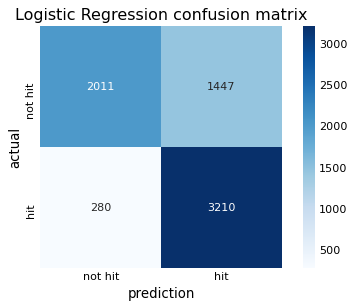

In [299]:
make_confusion_matrix(grid_log,threshold=.364,model_name='Logistic Regression')

Decision Tree

In [152]:
param_grid = {
    'max_depth':[90,120,150],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [2, 4, 6]
}

dt = DecisionTreeClassifier()
dt.fit(X_train,y_train)
grid_dt = GridSearchCV(dt, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_dt.fit(X_train, y_train)

proba_dt = .111
y_predict_dt = (grid_dt.predict_proba(X_train)[:,1] >= proba_dt)
y_predict_dt_test = (grid_dt.predict_proba(X_test)[:,1] >= proba_dt)

print("Best estimator: ", grid_dt.best_estimator_)
print("Best score at default proba: ", grid_dt.best_score_)

print(f'train score is {f1_score(y_train,y_predict_dt)}')
print(f'test score is {f1_score(y_test, y_predict_dt_test)}')

Best estimator:  DecisionTreeClassifier(max_depth=120, min_samples_leaf=5, min_samples_split=6)
Best score at default proba:  0.7490576709337237
train score is 0.867513385630681
test score is 0.77718668811085


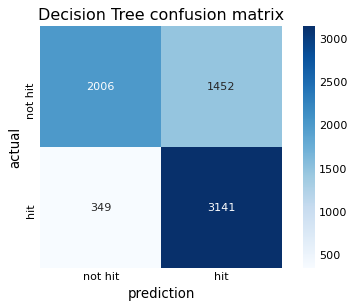

In [153]:
make_confusion_matrix(grid_dt,threshold=.111,model_name='Decision Tree')

Decision Tree Model best F1 score 0.779 at prob decision threshold >= 0.111


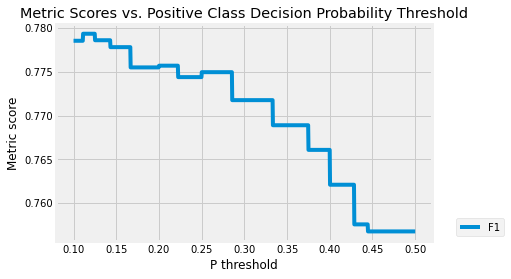

In [151]:
thresh_ps = np.linspace(.10,.5,1000)
model_val_probs = grid_dt.predict_proba(X_test)[:,1]

f1_scores = []
for p in thresh_ps:
    model_val_labels = model_val_probs >= p
    f1_scores.append(f1_score(y_test, model_val_labels))    
    
plt.plot(thresh_ps, f1_scores)

plt.title('Metric Scores vs. Positive Class Decision Probability Threshold')
plt.legend(['F1'], bbox_to_anchor=(1.05, 0), loc='lower left')
plt.xlabel('P threshold')
plt.ylabel('Metric score')

best_f1_score = np.max(f1_scores) 
best_thresh_p = thresh_ps[np.argmax(f1_scores)]

print('Decision Tree Model best F1 score %.3f at prob decision threshold >= %.3f' 
      % (best_f1_score, best_thresh_p))

Random Forest

In [240]:
param_grid = {
    'max_depth': [40,50],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [2, 4, 6],
    'n_estimators': [150,200]
}

rf = RandomForestClassifier()
rf.fit(X_train,y_train)
grid_rf = GridSearchCV(rf, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_rf.fit(X_train, y_train)

proba_rf = .414
y_predict_rf = (grid_rf.predict_proba(X_train)[:,1] >= proba_rf)
y_predict_rf_test = (grid_rf.predict_proba(X_test)[:,1] >= proba_rf)

df_cv = pd.DataFrame(grid_rf.cv_results_)

print("Best estimator: ", grid_rf.best_estimator_)
print("Best score at default proba: ", grid_rf.best_score_)

print(f'train score is {f1_score(y_train,y_predict_rf)}')
print(f'test score is {f1_score(y_test, y_predict_rf_test)}')

Best estimator:  RandomForestClassifier(max_depth=50, min_samples_leaf=4, min_samples_split=4,
                       n_estimators=150)
Best score at default proba:  0.818920766558635
train score is 0.9193158953722333
test score is 0.8258047767393562


Random Forest Model best F1 score 0.827 at prob decision threshold >= 0.406


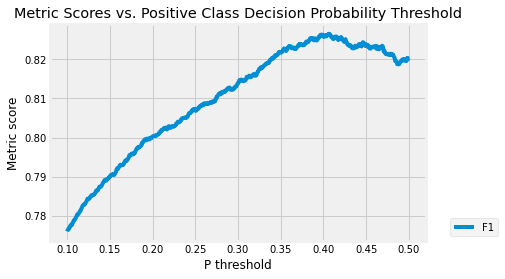

In [241]:
thresh_ps = np.linspace(.10,.5,1000)
model_val_probs = grid_rf.predict_proba(X_test)[:,1] 

f1_scores = []
for p in thresh_ps:
    model_val_labels = model_val_probs >= p
    f1_scores.append(f1_score(y_test, model_val_labels))    
    
plt.plot(thresh_ps, f1_scores)


plt.title('Metric Scores vs. Positive Class Decision Probability Threshold')
plt.legend(['F1'], bbox_to_anchor=(1.05, 0), loc='lower left')
plt.xlabel('P threshold')
plt.ylabel('Metric score')

best_f1_score = np.max(f1_scores) 
best_thresh_p = thresh_ps[np.argmax(f1_scores)]

print('Random Forest Model best F1 score %.3f at prob decision threshold >= %.3f' 
      % (best_f1_score, best_thresh_p))

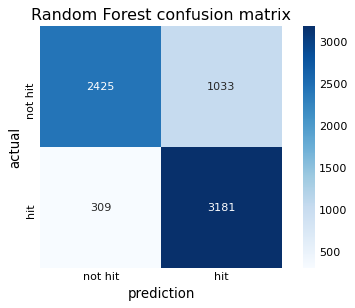

In [242]:
make_confusion_matrix(grid_rf,threshold=.414,model_name='Random Forest')

ADA Boost Tuning

In [187]:
#ADA Tuning

param_grid = {
    'learning_rate': [0.1, .1, 1],
    'algorithm': ['SAMME','SAMME.R'],
    'n_estimators': [25, 50, 100]
}

ada = AdaBoostClassifier()
ada.fit(X_train_scaled, y_train)
grid_ada = GridSearchCV(ada, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_ada.fit(X_train_scaled, y_train)

proba_ada = .498
y_predict_ada = (grid_ada.predict_proba(X_train_scaled)[:,1] >= proba_ada)
y_predict_ada_test = (grid_ada.predict_proba(X_test_scaled)[:,1] >= proba_ada)

print("Best estimator: ", grid_ada.best_estimator_)
print("Best Parameters: ", grid_ada.best_params_)
print("Best score at default proba: ", grid_ada.best_score_)

print(f'train score is {f1_score(y_train,y_predict_ada)}')
print(f'test score is {f1_score(y_test, y_predict_ada_test)}')

Best estimator:  AdaBoostClassifier(learning_rate=0.1, n_estimators=100)
Best Parameters:  {'algorithm': 'SAMME.R', 'learning_rate': 0.1, 'n_estimators': 100}
Best score at default proba:  0.8011814537963167
train score is 0.8050298242785748
test score is 0.8025329542517448


ADA Model best F1 score 0.803 at prob decision threshold >= 0.498


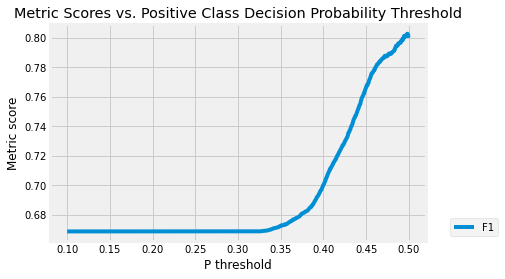

In [180]:
thresh_ps = np.linspace(.10,.5,1000)
model_val_probs = grid_ada.predict_proba(X_test_scaled)[:,1] 

f1_scores = []
for p in thresh_ps:
    model_val_labels = model_val_probs >= p
    f1_scores.append(f1_score(y_test, model_val_labels))    
    
plt.plot(thresh_ps, f1_scores)


plt.title('Metric Scores vs. Positive Class Decision Probability Threshold')
plt.legend(['F1'], bbox_to_anchor=(1.05, 0), loc='lower left')
plt.xlabel('P threshold')
plt.ylabel('Metric score')

best_f1_score = np.max(f1_scores) 
best_thresh_p = thresh_ps[np.argmax(f1_scores)]

print('ADA Model best F1 score %.3f at prob decision threshold >= %.3f' 
      % (best_f1_score, best_thresh_p))

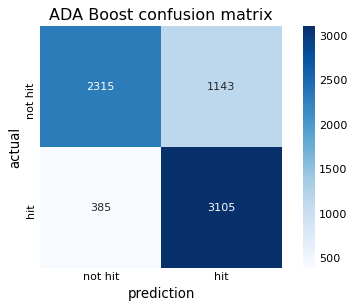

In [182]:
make_confusion_matrix(grid_ada,threshold=.498,model_name='ADA Boost')
#ADA Boost identified a large volume of hits correctly, but also had significant false positives

XGBoost

In [224]:
#XGBClassifier Tuning

param_grid = {
    'learning_rate': [.1,.2],
    'max_depth': [6,8],
    'n_estimators': [90,100],
    'gamma': [.1,.2],
    'subsample': [.5,1]
}

xg = xgb.XGBClassifier(use_label_encoder=False,eval_metric='logloss')
xg.fit(X_train, y_train)
grid_xg = GridSearchCV(xg, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_xg.fit(X_train, y_train)

proba_xg = .381
y_predict_xg = (grid_xg.predict_proba(X_train)[:,1] >= proba_xg)
y_predict_xg_test = (grid_xg.predict_proba(X_test)[:,1] >= proba_xg)

print("Best estimator: ", grid_xg.best_estimator_)
print("Best Parameters: ", grid_xg.best_params_)
print("Best score at default proba: ", grid_xg.best_score_)

print(f'train score is {f1_score(y_train,y_predict_xg)}')
print(f'test score is {f1_score(y_test, y_predict_xg_test)}')

Best estimator:  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0.2, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=90, n_jobs=8,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=0.5, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)
Best Parameters:  {'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 90, 'subsample': 0.5}
Best score at default proba:  0.8187603578066973
train score is 0.8454256650515033
test score is 0.8240717029449424


/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


XGBoost Model best F1 score 0.824 at prob decision threshold >= 0.381


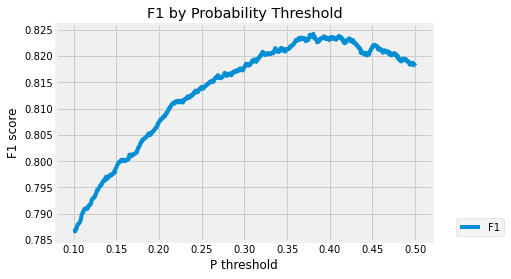

In [321]:
thresh_ps = np.linspace(.10,.5,1000)
model_val_probs = grid_xg.predict_proba(X_test)[:,1] 

f1_scores = []
for p in thresh_ps:
    model_val_labels = model_val_probs >= p
    f1_scores.append(f1_score(y_test, model_val_labels))    
    
plt.plot(thresh_ps, f1_scores)


plt.title('F1 by Probability Threshold')
plt.legend(['F1'], bbox_to_anchor=(1.05, 0), loc='lower left')
plt.xlabel('P threshold')
plt.ylabel('F1 score')
plt.savefig('Images/Prob_Threshold_XG')

best_f1_score = np.max(f1_scores) 
best_thresh_p = thresh_ps[np.argmax(f1_scores)]

print('XGBoost Model best F1 score %.3f at prob decision threshold >= %.3f' 
      % (best_f1_score, best_thresh_p))

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


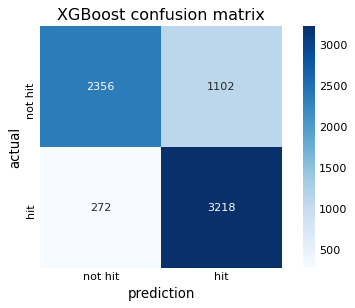

In [309]:
make_confusion_matrix(grid_xg,threshold=.381,model_name='XGBoost')

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


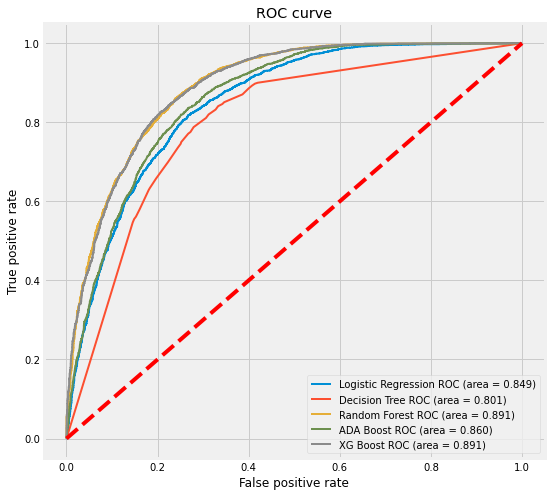

In [236]:
#ROC Curve
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, grid_log.predict_proba(X_test_scaled)[:,1])
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, grid_rf.predict_proba(X_test)[:,1])
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test, grid_dt.predict_proba(X_test)[:,1])
fpr_ada, tpr_ada, thresholds_ada = roc_curve(y_test, grid_ada.predict_proba(X_test_scaled)[:,1])
fpr_xg, tpr_xg, thresholds_xg = roc_curve(y_test, grid_xg.predict_proba(X_test)[:,1])

plt.figure(figsize=(8, 8))
plt.plot(fpr_lr, tpr_lr,lw=2,
         label='%s ROC (area = %0.3f)' % 
         ('Logistic Regression', roc_auc_score(y_test, grid_log.predict_proba(X_test_scaled)[:,1])))
plt.plot(fpr_dt, tpr_dt,lw=2,
         label='%s ROC (area = %0.3f)' % 
         ('Decision Tree', roc_auc_score(y_test, grid_dt.predict_proba(X_test)[:,1])))
plt.plot(fpr_rf, tpr_rf,lw=2,
         label='%s ROC (area = %0.3f)' % 
         ('Random Forest', roc_auc_score(y_test, grid_rf.predict_proba(X_test)[:,1])))
plt.plot(fpr_ada, tpr_ada,lw=2,
         label='%s ROC (area = %0.3f)' % 
         ('ADA Boost', roc_auc_score(y_test, grid_ada.predict_proba(X_test_scaled)[:,1])))
plt.plot(fpr_xg, tpr_xg,lw=2,
         label='%s ROC (area = %0.3f)' % 
         ('XG Boost', roc_auc_score(y_test, grid_xg.predict_proba(X_test)[:,1])))

plt.plot([0,1],[0,1],c='red',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.savefig('ROC curve.png');

In [295]:
metrics = list(zip(['Logistic','Decision Tree','Random Forest','ADA Boost','XG Boost'],
         [f1_score(y_train,y_predict_log), f1_score(y_train,y_predict_dt),f1_score(y_train,y_predict_rf),
         f1_score(y_train,y_predict_ada),f1_score(y_train,y_predict_xg)],
                   
         [f1_score(y_test, y_predict_log_test),f1_score(y_test, y_predict_dt_test),
         f1_score(y_test, y_predict_rf_test),f1_score(y_test, y_predict_ada_test),
         f1_score(y_test, y_predict_xg_test)]

                  ))

metrics_df = pd.DataFrame(metrics,columns=['Model','Train F1','Test F1'])
metrics_df.round(3).to_csv('metrics.csv')
metrics_df

Model  Train F1   Test F1
0       Logistic  0.791595  0.788020
1  Decision Tree  0.867513  0.777187
2  Random Forest  0.919316  0.825805
3      ADA Boost  0.805030  0.802533
4       XG Boost  0.845426  0.824072

View predictions in action

In [318]:
df = X.copy()

df['pred_xg'] = (grid_xg.predict_proba(df)[:,1] >= proba_xg).astype(int)
df['actual'] = spotify_df2['On_chart']
df['track_title'] = spotify_df2['track_title']
df['artist_name'] = spotify_df2['artist_name']
df[(df['actual'] == 1) & (df['pred_xg'] == 0)& (df['track_title'].str.contains('Controlla'))].head()

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


duration_m  energy  acousticness  instrumentalness  valence  \
17406    4.087117   0.476        0.0773               0.0    0.347   

       speechiness  loudness  time_signature_4  lowloud  energyxdance  \
17406        0.249   -11.076                 0        1      0.288932   

       pred_xg  actual track_title artist_name  
17406        0       1   Controlla       Drake

In [320]:
df[(df['actual'] == 1) & (df['pred_xg'] == 1) & (df['track_title'].str.contains('Goosebumps - Remix'))].head()

duration_m  energy  acousticness  instrumentalness  valence  \
34689    2.713383   0.593         0.418               0.0    0.808   

       speechiness  loudness  time_signature_4  lowloud  energyxdance  \
34689       0.0379    -7.846                 1        0      0.498713   

       pred_xg  actual         track_title   artist_name  
34689        1       1  Goosebumps - Remix  Travis Scott

A good example of the algorithm working correctly is the song "Goosebumps - Remix" by Travis Scott. The metrics for fields such as valence, energy, and energyxdance are all favorable and in line with what we expect to come out of a hit song. On the other end, the song "Controlla" by Drake was misclassified as a non-hit due to its unfavorable features, but presumably got popular due to the artist's fame and reputation.